# Question 4

In this question, you need to install OpenAI gym (http://gym.openai.com/docs/). Once the
gym is installed, you have to implement Q-learning for the FrozenLake environment
(https://gym.openai.com/envs/FrozenLake-v0/) in python using the gym library and show
the rewards obtained. You may use a discount factor of 0.95. Please provide the following
two things in your solution for this question:

(a) Code that implements Q-learning for Frozenlake example in gym? Copy and paste
the code in the solution pdf, and provide the actual code file also.

(b) For each episode, compute the total accumulated reward (also called episode
return). Plot the average return (over the last 100 episodes) while your agent is
learning (x-axis will be the episode number, y-axis will be the average return over the
last 100 episodes). Make sure that you train for sufficiently many episodes so that
convergence occurs.


The goal in this question is to ensure you familiarize yourself with OpenAI and understand
how to implement Q-learning in OpenAI. There are many resources available online on
implementing Q-learning in OpenAI and the right value of learning rate for the frozen lake
example. You are free to refer to them, but please write your own code. Tabular Q-learning
should work in this question.

In [1]:
import numpy as np
import gym
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
# Create environment
env = gym.make("FrozenLake-v0")

In [3]:
# Number of actions for the env
env.env.nA

4

In [4]:
# Number of states for the env
env.env.nS

16

In [5]:
env.env.P[0][1]

[(0.3333333333333333, 0, 0.0, False),
 (0.3333333333333333, 4, 0.0, False),
 (0.3333333333333333, 1, 0.0, False)]

In [6]:
env.render()


SFFF
FHFH
FFFH
HFFG


In [11]:
def stats(env, policy, episodes=100):
  misses = 0
  steps_list = []
  for episode in range(episodes):
    observation = env.reset()
    steps=0
    while True:
      
      action = policy[observation]
      observation, reward, done, _ = env.step(action)
      steps+=1
      if done and reward == 1:
        
        steps_list.append(steps)
        break
      elif done and reward == 0:
        
        misses += 1
        break
  y = (100 - ((misses/episodes) * 100))
  steps_num = np.mean(steps_list)
  return y,steps_num


def policy(env,stateValue, discount=0.95):
  policy = [0 for i in range(env.nS)]
  for state in range(env.nS):
    action_values = []
    for action in range(env.nA):
      action_value = 0
      for i in range(len(env.P[state][action])):
        prob, next_state, r, _ = env.P[state][action][i]
        action_value += prob * (r + discount * stateValue[next_state])
      action_values.append(action_value)
    best_action = np.argmax(np.asarray(action_values))
    policy[state] = best_action
  return policy 

def question_4(env, max_iterations=100000, discount=0.95):
  plot_dic = {"accuracy per 100 episodes":[],
  "episodes":[],
  "av_rew_100":[],
  "av_steps_100":[]}
  stateValue = [0 for i in range(env.nS)]
  newStateValue = stateValue.copy()
  for i in range(max_iterations):
    for state in range(env.nS):
      action_values = []      
      for action in range(env.nA):
        state_value = 0
        for index in range(len(env.P[state][action])):
          prob, next_state, reward, done = env.P[state][action][index]
          state_action_value = prob * (reward + discount*stateValue[next_state])
          state_value += state_action_value
        action_values.append(state_value)      
        best_action = np.argmax(np.asarray(action_values))   
        newStateValue[state] = action_values[best_action]  
    if i in [ep for ep in range(100,(max_iterations + 1),100)]: # extract policy and score for each 100 episodes 

        policy_ = policy(env,newStateValue)
        plot_dic["accuracy per 100 episodes"].append(stats(env,policy_)[0])
        plot_dic["episodes"].append(i)
        plot_dic["av_rew_100"].append(np.mean(newStateValue))
        plot_dic["av_steps_100"].append(stats(env,policy_)[1])

    elif i > 1001: 
      if sum(stateValue) - sum(newStateValue) < 1e-04:   # if there is negligible difference break the loop
        print("Episodes:",i)
        break
        
    else:
      stateValue = newStateValue.copy()

  df = pd.DataFrame(plot_dic)
  fig, axs = plt.subplots(3,figsize=(18, 10),sharex = False)
  plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=0.4)
  fig.suptitle('Average Reward, Steps and Accuracy per 100 Episodes',fontsize=20)
  sns.lineplot(data = df, x="episodes",y="accuracy per 100 episodes", ax=axs[2])
  axs[2].set_title("Times we achieve goal state per 100 episodes",fontsize=16)
  sns.lineplot(data = df, x="episodes",y="av_rew_100",ax = axs[0])

  axs[0].set_title("Average reward per 100 episodes",fontsize=16)
  sns.lineplot(data = df, x="episodes",y="av_steps_100",ax = axs[1])
  axs[1].set_title("Average steps taken to achieve goal state per 100 episodes",fontsize=16)
  plt.plot()
  print("Final_policy:",policy(env,stateValue)) 

Episodes: 1002
Final_policy: [0, 3, 0, 3, 0, 0, 0, 0, 3, 1, 0, 0, 0, 2, 1, 0]


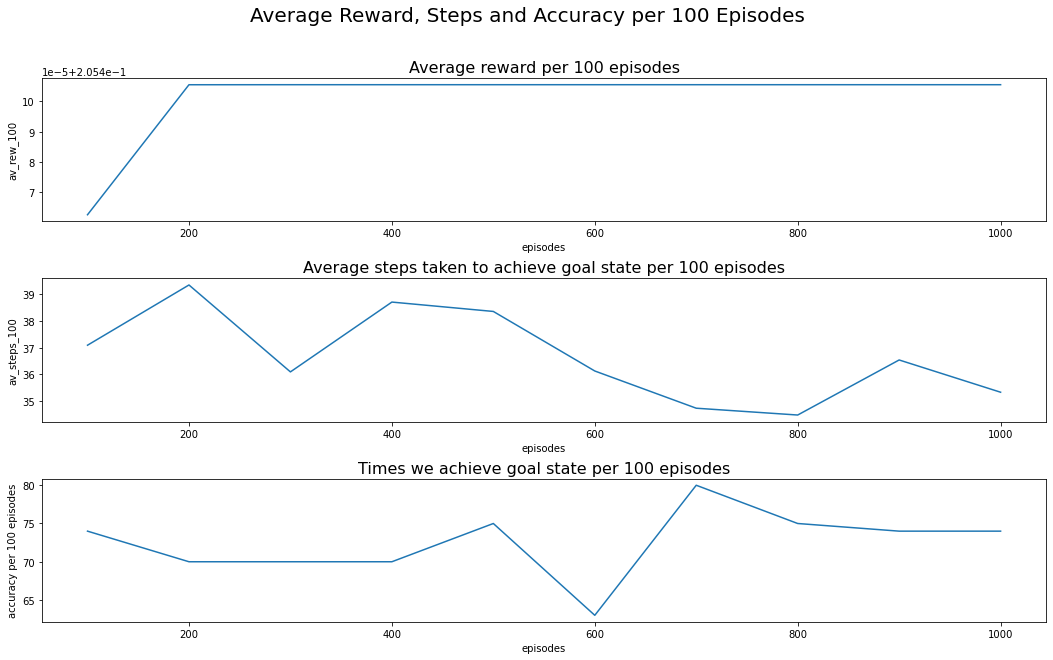

In [12]:
question_4(env)

# Question 5

In this question, you will employ Singular Value Decomposition to obtain word embeddings
and compare the generated word embeddings with the word embeddings generated using
word2vec. The corpus (or dataset) to be considered is “200Reviews.csv”. You need to do the
following:

(a) Parse the reviews in “200Reviews.csv”, i.e., divide reviews into sentences and sentences
into words and remove the stop words. You can employ the “NLP-pipeline-example.ipynb”
example we talked about in class.

(b) Create the co-occurrence matrix for all the remaining words (after stop words are
eliminated), where the window of co-occurrence is 5 on either side of the word.

(c) Apply SVD and obtain word embeddings of size 100.

Then, please generate word embeddings of size 100 using Word2Vec.pynb (from the NLP
lecture) on the same “200Reviews.csv” dataset. Please show comparison on few examples
to understand which method works better. Note your observations in your solution.

In [1]:
import numpy as np
import pandas as pd
import nltk
from nltk.stem import WordNetLemmatizer
import sys
from nltk.corpus import wordnet
from nltk.corpus import stopwords
from nltk.parse.malt import MaltParser
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\monol\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\monol\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\monol\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\monol\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

## (a) Parse the reviews in “200Reviews.csv”, i.e., divide reviews into sentences and sentences into words and remove the stop words. 

In [2]:
df = pd.read_csv("Q5/200Reviews.csv")

In [3]:
df = df.iloc[::,1:]

In [4]:
df

,id,sentiment,review
0,"""5814_8""",1,"""With all this stuff going down at the moment ..."
1,"""2381_9""",1,"""\""The Classic War of the Worlds\"" by Timothy ..."
2,"""7759_3""",0,"""The film starts with a manager (Nicholas Bell..."
3,"""3630_4""",0,"""It must be assumed that those who praised thi..."
4,"""9495_8""",1,"""Superbly trashy and wondrously unpretentious ..."
...,...,...,...
195,"""8807_9""",1,"""This is a collection of documentaries that la..."
196,"""12148_10""",1,"""This movie has a lot of comedy, not dark and ..."
197,"""10771_2""",0,"""Have not watched kids films for some years, s..."
198,"""6766_3""",0,"""You probably heard this phrase when it come t..."


## a)

In [5]:
paragraph = ""

In [6]:
for i in df["review"]:
    paragraph += i

In [7]:
paragraph

was time for six man tag action as the Smoking Gunns (Bart and BIlly) and Tatanka defeated The Headshrinkers (Samu and Fatu) and Bam Bam Bigelow with Tatanka pinning Samu.<br /><br />This brings us to the main event with Yokozuna, flanked by Jim Cornette and Mr Fuji, putting the WWE Title on the line against Lex Luger and it was all on board the Lex Express. Lex came out attacking, but Yokozuna took control. Lex came back though as he was able to avoid a banzai drop and then body slam Yokozuna before knocking him out of the ring. Luger then attacked Cornette and Fuji as Yokozuna was counted out. Luger had won a fine match!!!!! Balloons fell from the ceiling. The heroes all came out to congratulate him on his win. Yokozuna may have retained the title, but Luger had proved he could be beaten. The only question was, who could beat him in the ring and get that title off him?""I really don\'t get all the adulation that this film has received. It\'s mawkish, unnecessarily manipulative and do

In [8]:
#Step1: Sentence segmentation

sentences = nltk.sent_tokenize(paragraph)

print("\n\n"+repr(len(sentences))+" sentences found in the paragraph. They are as follows:")
for k in range(len(sentences)):
    print("("+repr(k+1)+") "+sentences[k])

really don't get all the adulation that this film has received.
(1815) It's mawkish, unnecessarily manipulative and dodges many of the big issues - ie Nash's affairs and his predilection for having sex with men in public places.
(1816) That, I suppose, in the context of a commercial Hollywood film is just about tolerable, but what's with all the praise for Russell Crowe's performance?
(1817) The man just seems to shuffle about, clutching his briefcase and wearing a grungy hat and somehow that seems to qualify as fine acting?
(1818) Anyone who has ever known a person with mental health problems will realise that Crowe's performance is little short of caricature.
(1819) It is also rather offensive.
(1820) And, dare I say, just on the right side of being truly terrible""\"De vierde man\" (The Fourth Man, 1984) is considered one of the best European pycho thrillers of the eighties.
(1821) This last work of Dutch director Paul Verhoeven in his home country before he moved to Hollywood to be

In [9]:
#Step 2: Word tokenization

for k in range(len(sentences)):
    # word tokenizer will keep the punctuations. To get rid of punctuations, use nltk.RegexpTokenizer(r'\w+').tokenize(sentences[k]) 
    # words = nltk.word_tokenize(sentences[k])
    words = nltk.RegexpTokenizer(r'\w+').tokenize(sentences[k])
    print("Words in sentence "+repr(k+1)+" are: ")
    wordlist=[]
    for w in words:
        wordlist.append(w)
    print(wordlist)

r', 'the', 'State', 'Department', 'officials', 'who', 'offer', 'her', 'the', 'job', 'have', 'a', 'hidden', 'agenda', 'br', 'br', 'A', 'map', 'we', 'see', 'shows', 'Ohtar', 'lying', 'on', 'the', 'borders', 'of', 'Saudi', 'Arabia', 'and', 'South', 'Yemen', 'in', 'an', 'area', 'of', 'barren', 'desert', 'known', 'as', 'the', 'Rub', 'al', 'Khali', 'or', 'Empty', 'Quarter']
Words in sentence 1877 are: 
['In', 'real', 'life', 'a', 'state', 'in', 'this', 'location', 'would', 'have', 'a', 'population', 'of', 'virtually', 'zero', 'and', 'virtually', 'zero', 'strategic', 'value', 'but', 'for', 'the', 'purposes', 'of', 'the', 'film', 'we', 'have', 'to', 'accept', 'that', 'Ohtar', 'is', 'of', 'immense', 'strategic', 'importance', 'in', 'the', 'Cold', 'War', 'and', 'that', 'the', 'American', 'government', 'who', 'are', 'keen', 'to', 'build', 'a', 'military', 'base', 'there', 'need', 'to', 'do', 'all', 'that', 'they', 'can', 'in', 'order', 'to', 'keep', 'on', 'the', 'good', 'side', 'of', 'its', 'rule

In [10]:
#Step 3: Predicting parts off speech for each token
# You can use nltk.help.upenn_tagset() to get the description of each of pos tag.
#Uncomment following line to print the list of all tags
#nltk.download('tagsets')
#nltk.help.upenn_tagset()
for k in range(len(sentences)):
    words = nltk.RegexpTokenizer(r'\w+').tokenize(sentences[k])
    tagged_words = nltk.pos_tag(words)
    print("Tagged Words in sentence "+repr(k+1)+" are: ")
    print(tagged_words)

 ('nothing', 'NN'), ('better', 'RBR'), ('to', 'TO'), ('do', 'VB'), ('although', 'IN'), ('I', 'PRP'), ('suggest', 'VBP'), ('watching', 'VBG'), ('your', 'PRP$'), ('head', 'NN'), ('cleaner', 'NN'), ('tape', 'NN'), ('that', 'WDT'), ('would', 'MD'), ('be', 'VB'), ('more', 'RBR'), ('entertaining', 'JJ')]
Tagged Words in sentence 1912 are: 
[('Skip', 'VB'), ('it', 'PRP'), ('and', 'CC'), ('rent', 'VB'), ('Girl', 'NNP'), ('s', 'VB'), ('Nite', 'NNP'), ('Out', 'NNP'), ('instead', 'RB'), ('br', 'VBD'), ('br', 'RB'), ('Rated', 'VBN'), ('R', 'NNP'), ('for', 'IN'), ('Strong', 'NNP'), ('Graphic', 'NNP'), ('Violence', 'NNP'), ('Profanity', 'NNP'), ('Brief', 'NNP'), ('Nudity', 'NNP'), ('and', 'CC'), ('Sexual', 'NNP'), ('Situations', 'NNP')]
Tagged Words in sentence 1913 are: 
[('I', 'PRP'), ('have', 'VBP'), ('seen', 'VBN'), ('about', 'IN'), ('a', 'DT'), ('thousand', 'JJ'), ('horror', 'NN'), ('films', 'NNS')]
Tagged Words in sentence 1914 are: 
[('my', 'PRP$'), ('favorite', 'JJ'), ('type', 'NN'), ('This'

In [11]:
#Step 4: Text Lemmatization
#As we are using wordnet Lemmatizer and the the standard NLTK pos tags are treebank tags, we need to convert the treebank tag
#to wordnet tags. 
def get_wordnet_pos(treebank_tag):

    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return wordnet.VERB
    elif treebank_tag.startswith('N'):
        return wordnet.NOUN
    elif treebank_tag.startswith('R'):
        return wordnet.ADV
    else:
        return ''
    
wordnet_lemmatizer = WordNetLemmatizer()
for k in range(len(sentences)):
    words = nltk.RegexpTokenizer(r'\w+').tokenize(sentences[k])
    tagged_words = nltk.pos_tag(words)
    lemmatized_wordlist=[]
    print("Word:Lemmatized Word in sentence "+repr(k+1)+" are: ")
    for w in tagged_words:
        wordnettag=get_wordnet_pos(w[1])
        if wordnettag == '':
            lemmatizedword = wordnet_lemmatizer.lemmatize(w[0].lower())
        else:
            lemmatizedword = wordnet_lemmatizer.lemmatize(w[0].lower(),pos=wordnettag)
        if w[0].istitle():
            lemmatizedword = lemmatizedword.capitalize()
        elif w[0].upper()==w[0]:
            lemmatizedword = lemmatizedword.upper()
        else:
            lemmatizedword = lemmatizedword
        lemmatized_wordlist.append((w[0],lemmatizedword))
            
    print(lemmatized_wordlist)


inning', 'beginning'), ('has', 'have'), ('to', 'to'), ('do', 'do'), ('with', 'with'), ('the', 'the'), ('film', 'film')]
Word:Lemmatized Word in sentence 1920 are: 
[('Something', 'Something'), ('Weird', 'Weird'), ('has', 'have'), ('little', 'little'), ('to', 'to'), ('offer', 'offer')]
Word:Lemmatized Word in sentence 1921 are: 
[('Save', 'Save'), ('yourself', 'yourself'), ('the', 'the'), ('pain', 'pain')]
Word:Lemmatized Word in sentence 1922 are: 
[('This', 'This'), ('is', 'be'), ('a', 'a'), ('collection', 'collection'), ('of', 'of'), ('documentaries', 'documentary'), ('that', 'that'), ('last', 'last'), ('11', '11'), ('minutes', 'minute'), ('9', '9'), ('seconds', 'second'), ('and', 'and'), ('1', '1'), ('frame', 'frame'), ('from', 'from'), ('artists', 'artist'), ('all', 'all'), ('over', 'over'), ('the', 'the'), ('world', 'world')]
Word:Lemmatized Word in sentence 1923 are: 
[('The', 'The'), ('documentaries', 'documentary'), ('are', 'be'), ('varied', 'varied'), ('and', 'and'), ('deal', 

In [12]:
#Step 5: Identifying stop words
stopWords = set(stopwords.words('english'))
for k in range(len(sentences)):
    words = nltk.RegexpTokenizer(r'\w+').tokenize(sentences[k])
    wordlist_wo_stopwords=[]
    print("Words in sentence "+repr(k+1)+" without stop words are: ")
    for w in words:
        if w not in stopWords:
            wordlist_wo_stopwords.append(w)
    print(wordlist_wo_stopwords)


D', 'specifically', 'I', 'dabbled', 'one', 'brethren']
Words in sentence 1849 without stop words are: 
['M', 'M', 'also', 'made', 'heyday', 'D', 'D', 'major', 'controversy', 'engrossing', 'people', 'could', 'lose', 'touch', 'reality', 'worshiping', 'Satan', 'without', 'knowing', 'blah', 'blah']
Words in sentence 1850 without stop words are: 
['I', 'suppose', 'legitimate', 'concern', 'one', 'point', 'extremely', 'rare', 'dates', 'movie', 'horrendously', 'br', 'br', 'We', 'meet', '4', 'young', 'college', 'students', 'play', 'aptly', 'named', 'Mazes', 'Monsters', 'socialize', 'little', 'time', 'away', 'mundane', 'life']
Words in sentence 1851 without stop words are: 
['Except', 'M', 'M', 'presented', 'boring', 'mundane', 'lives']
Words in sentence 1852 without stop words are: 
['None', 'allure', 'gaming', 'presented', 'Jay', 'Jay', 'request', 'take', 'M', 'M', 'real', 'world', 'comes', 'nowhere']
Words in sentence 1853 without stop words are: 
['It', 'excuse', 'make', 'one', 'characters',

## b) Create the co-occurrence matrix for all the remaining words (after stop words are eliminated), where the window of co-occurrence is 5 on either side of the word.

In [13]:
#Step 6: Create general wordlist for co occurence matrix
general_wordlist = []
stopWords = set(stopwords.words('english'))
for k in range(len(sentences)):
    words = nltk.RegexpTokenizer(r'\w+').tokenize(sentences[k])
    wordlist_wo_stopwords=[]

    for w in words:
        if w not in stopWords:
            wordlist_wo_stopwords.append(w)
    general_wordlist.append(wordlist_wo_stopwords)

In [14]:
from collections import defaultdict
def co_occurrence(sentences, window_size):
    d = defaultdict(int)
    vocab = set()
    for text in sentences:

        # iterate over sentences
        for i in range(len(text)):
            token = text[i]
            vocab.add(token)  # add to vocab
            next_token = text[i+1 : i+1+window_size]
            for t in next_token:
                key = tuple( sorted([t, token]) )
                d[key] += 1

    # formulate the dictionary into dataframe
    vocab = sorted(vocab) # sort vocab
    df = pd.DataFrame(data=np.zeros((len(vocab), len(vocab)), dtype=np.int16),
                      index=vocab,
                      columns=vocab)
    for key, value in d.items():
        df.at[key[0], key[1]] = value
        df.at[key[1], key[0]] = value
    return df

In [15]:
co_occurrence(general_wordlist,5)

,0,000,1,10,100,101,11,117,12,13th,...,z,zapped,zero,zip,zombie,zombies,zone,zoom,zooms,Êxtase
0,0,0,0,2,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
000,0,0,0,1,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,2,0,0,1,0,0,0,...,0,0,0,0,3,0,0,0,0,0
10,2,1,2,3,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
100,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
zombies,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
zone,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
zoom,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
zooms,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [16]:
cooccurence = co_occurrence(general_wordlist,5)

## Apply SVD and obtain word embeddings of size 100

In [18]:
from sklearn.decomposition import TruncatedSVD
svd = TruncatedSVD(n_components=100)
svd_reduced  = svd.fit_transform(cooccurence)
svd_explained = svd.explained_variance_ratio_.sum()
print('Explained Variance =', round(svd_explained, 3))

Explained Variance = 0.825


In [19]:
#rebuild the cooccurance matrix
cooccurance_reduced = pd.DataFrame(svd_reduced, index = list(cooccurence.index), columns=[[*range(1,101)]])
cooccurance_reduced.sample(5)

,1,2,3,4,5,6,7,8,9,10,...,91,92,93,94,95,96,97,98,99,100
eighty,0.208974,0.290983,0.002500,0.183836,-0.217832,0.368485,-0.317438,-0.309347,0.004498,0.071193,...,0.053942,-0.020486,0.051262,-0.088176,0.018753,0.000669,0.072587,0.132077,-0.127613,0.093492
chanting,0.057897,0.012824,-0.013097,-0.007653,-0.056049,-0.048923,-0.070348,0.005328,-0.001052,-0.026925,...,0.027469,-0.034363,-0.047082,-0.044118,0.120887,0.028641,0.060767,-0.038341,-0.011005,0.057299
Cinemax,0.180341,0.202141,0.070545,0.005348,-0.114709,0.176533,-0.375463,0.505523,-0.470326,-0.179566,...,0.191144,0.008046,-0.097651,-0.049811,-0.131802,0.066090,-0.037616,-0.052181,0.114195,0.056752
hanging,0.081588,0.091873,0.068605,-0.020933,-0.097416,0.034085,-0.011022,-0.031486,-0.009726,-0.048256,...,-0.016149,0.045168,0.005059,0.157017,-0.234884,0.606797,-0.300303,-0.385588,0.125653,-0.079271
victorious,1.958751,-1.017680,0.193933,-0.067055,-0.134160,0.219382,0.508646,0.132666,-0.237422,-0.092653,...,-0.045546,0.015921,-0.089304,0.012387,0.045616,0.004489,0.017079,-0.053637,-0.015719,0.040672


In [26]:
# Find out which two words are similar, based on cosine similarity
from itertools import combinations
from sklearn.metrics.pairwise import cosine_similarity
words = ['drama', 'zombie', 'enemy', 'suspense']

sim_result = []

for i in [*combinations(words,2)]:

    word_1 = [cooccurance_reduced.loc[i[0]].values]

    word_2 = cooccurance_reduced.loc[i[1]].values.reshape(1, -1)
    cos_sim = cosine_similarity(word_1, word_2)
    
    sim_result.append([i[0], i[1], cos_sim[0][0]])

In [27]:
df_svd = pd.DataFrame(sim_result, columns=['word1', 'word2', 'cosine_similarity']).sort_values(by='cosine_similarity', ascending=False)
print(df_svd)

    word1     word2  cosine_similarity
2   drama  suspense           0.393876
0   drama    zombie           0.270972
5   enemy  suspense           0.045016
3  zombie     enemy           0.043018
4  zombie  suspense           0.041196
1   drama     enemy          -0.072959


In [29]:
# finding the top 5 similar words
word = 'drama'

total_score= pd.DataFrame(cooccurence.index, columns = ['word'])
total_score['cosine_sim'] = 0

embedding_1 = cooccurance_reduced.loc[word].values.reshape(1, -1)

for i in cooccurence.index:
    embedding_2 = cooccurance_reduced.loc[i].values.reshape(1, -1)
    cos_lib = cosine_similarity(embedding_1, embedding_2)
    total_score.loc[total_score['word']==i, 'cosine_sim'] = cos_lib[0][0]

print('top 5 similar words to', word)
print(total_score.sort_values(by=['cosine_sim'], ascending = False)[1:6])

top 5 similar words to drama
            word  cosine_sim
6910      sports    0.696246
3731  dreadfully    0.678115
5678      parody    0.671254
6332    resemble    0.650590
3919     episode    0.641615
